# Preprocessing: California Housing Dataset

In this exercise you will pre-prcess the [California housing dataset](https://www.kaggle.com/camnugent/california-housing-prices).  

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
from sklearn.impute import KNNImputer

InteractiveShell.ast_node_interactivity = "all"
pd.set_option('precision', 3)

## 1. BASIC INSPECTION

In [2]:
housing = pd.read_csv("housing.csv", header=0, delimiter=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.325,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.301,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.257,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.643,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.846,342200.0,NEAR BAY


Population is the total number of people living in the block. Households are the number of families in the block. 

population/households = family size.

In [3]:
housing.shape

(20640, 10)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

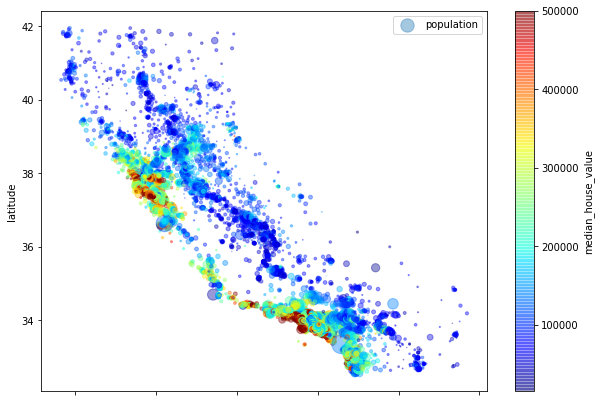

In [4]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

Units:

- median_income is in 10 thousand dollars
- median_house_value is in dollars

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000,20640.000,20640.000,20640.000,20433.000,20640.000,20640.00,20640.000,20640.000
mean,-119.570,35.632,28.639,2635.763,537.871,1425.477,499.54,3.871,206855.817
std,2.004,2.136,12.586,2181.615,421.385,1132.462,382.33,1.900,115395.616
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.00,0.500,14999.000
25%,-121.800,33.930,18.000,1447.750,296.000,787.000,280.00,2.563,119600.000
50%,-118.490,34.260,29.000,2127.000,435.000,1166.000,409.00,3.535,179700.000
75%,-118.010,37.710,37.000,3148.000,647.000,1725.000,605.00,4.743,264725.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.00,15.000,500001.000


The `median_income` will be normalized later.

In [6]:
housing.median_income = housing.median_income*10000

In [7]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

## 2. MISSING VALUES

Text(0.5, 1.0, 'Amount Of Missing Values')

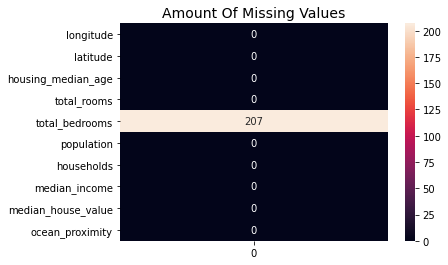

In [8]:
plt.title('Amount Of Missing Values',fontsize=14)
ax = sn.heatmap(pd.DataFrame(housing.isna().sum()),annot=True,fmt='d')
plt.show()

### 2.1. Imputation

In [9]:
ft_data = housing.loc[:, housing.columns != 'ocean_proximity']
imputer = KNNImputer(n_neighbors=1)
imputer.fit(ft_data)
X = imputer.transform(ft_data)
tmp = pd.DataFrame(X, columns=ft_data.columns)
tmp['ocean_proximity'] = housing['ocean_proximity']
housing = tmp

KNNImputer(n_neighbors=1)

In [10]:
housing.columns[housing.isna().any()].tolist()

[]

## 3. OUTLIERS

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

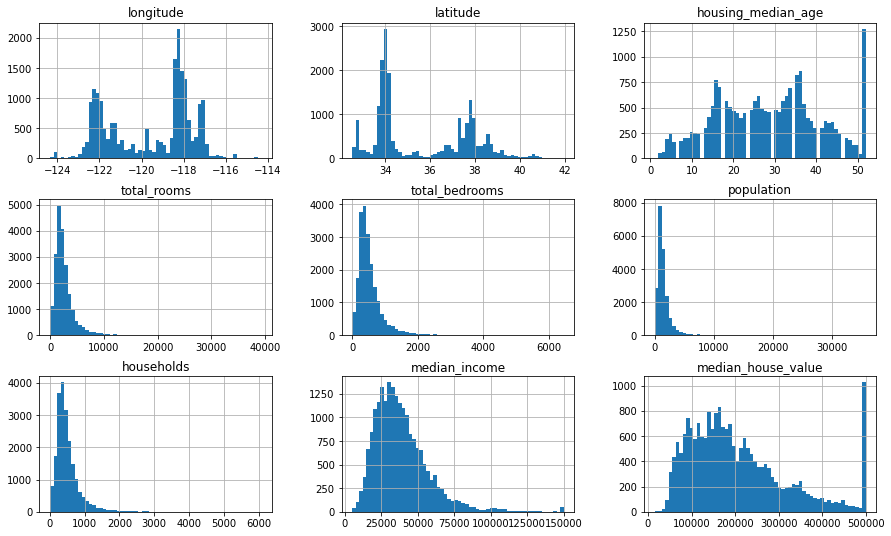

In [11]:
housing.hist(bins=60, figsize=(15,9))

Odd Patterns & Outliers ( Data distribution which slightly sticks out )

- On first impression, a few outlier (inconsistent with entire set) groups are present in our data; possibly due to the way in which the data was sampled ( 'housing_median_age' & 'median_house_value' )
- House_median_age is one possible feature with such outliers. Also having a lot of local peaks (all are quite gradual) but one really odd peak at the maximum value stands out. It has some slight discontinuity in data (which becomes visible with the adjustment of bins)
- Feature Median_house_value has an odd peak at its maximum value (around 500k), which could be an outlier.

Less Notable Outiers

- We have quite a few skewed (less centralised) data distributions, 6 features have such distributions, which is quite a lot and slightly concerning since we are going to use a relatively simple model.
- The range of the x axis for some of these features is quite broad (eg. population), indicating we have quite a few outliers, but unlike the first two, we can apply transformation to features and attempt to correct it.
- Population, total_bedrooms and total_rooms represent somewhat connected things, also have similar distribution which is skewed towards smaller values.


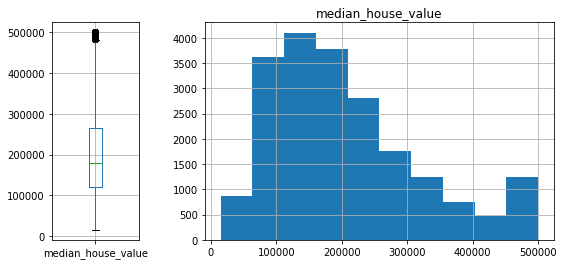

In [12]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,4))
housing.boxplot(column='median_house_value',ax=axes[0]);
housing.hist(column='median_house_value', ax=axes[1]);

### 3.1 Local Outlier Factor

In [13]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=20)
result = local_outlier_factor.fit_predict(housing['median_house_value'].values.reshape(-1, 1))

outliers = result == -1 
no_outliers = result == 1

Counter(result)

Counter({1: 19943, -1: 697})

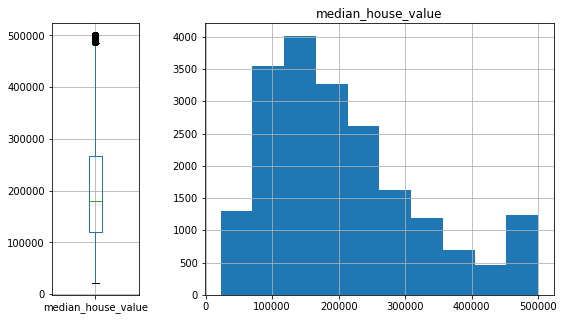

In [14]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
housing[no_outliers].boxplot(column='median_house_value',ax=axes[0]);
housing[no_outliers].hist(column='median_house_value', ax=axes[1]);

### 3.2. IQR

In [15]:
def filter_iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    small_outliers = df[col] < (q1 - 1.5 * iqr)
    big_outliers = df[col] > (q3 + 1.5 * iqr)
    print(sum(small_outliers), sum(big_outliers))
    return df[~(small_outliers | big_outliers)]
    
housing = filter_iqr(housing, 'median_house_value')

0 1071


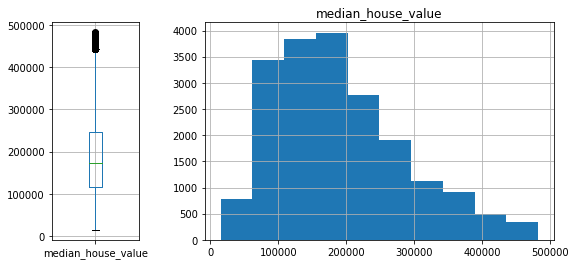

In [16]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,4))
housing.boxplot(column='median_house_value',ax=axes[0]);
housing.hist(column='median_house_value', ax=axes[1]);

## 4. DERIVATION OF NEW VARIABLES: FEATURE EXTRACTION

7 650


<ipython-input-17-9d0f5d3ca0f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing['family_size'] = housing.population/housing.households


<AxesSubplot:>

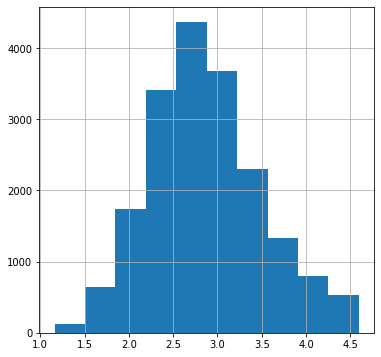

In [17]:
housing['family_size'] = housing.population/housing.households
housing = filter_iqr(housing, 'family_size')
housing.family_size.hist(figsize=(6,6))

## 5. RECAP

In [18]:
housing_new = housing.copy()
                   
housing_new.describe(include='all')
housing_new.shape

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,family_size
count,18912.000,18912.000,18912.000,18912.000,18912.000,18912.000,18912.000,18912.000,18912.000,18912,18912.000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8137,NaN
mean,-119.589,35.685,28.281,2657.478,545.510,1426.346,506.714,36923.923,192482.101,NaN,2.866
std,2.015,2.161,12.547,2182.547,421.388,1088.805,382.669,15623.933,95983.112,NaN,0.630
min,-124.350,32.540,1.000,2.000,2.000,5.000,2.000,4999.000,14999.000,NaN,1.161
25%,-121.790,33.940,18.000,1469.000,301.000,794.750,285.000,25417.000,116700.000,NaN,2.435
50%,-118.570,34.300,28.000,2144.000,442.000,1171.000,416.000,34784.000,175300.000,NaN,2.812
75%,-118.000,37.740,37.000,3165.000,654.000,1727.000,611.000,46111.000,249500.000,NaN,3.247


(18912, 11)

## 6. GAUSSIANITY & TRANSFORMATIONS

<AxesSubplot:>

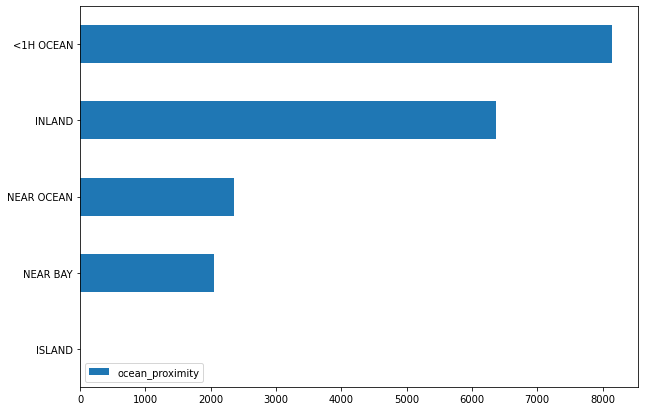

In [19]:
housing_new.ocean_proximity.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(10,7))
plt.legend()
# sn.color_palette()
# sn.histplot(data=housing_new, y="ocean_proximity", hue="island")

<AxesSubplot:>

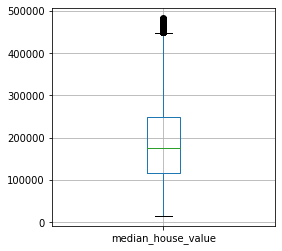

In [20]:
housing_new.boxplot(column='median_house_value', figsize=(4,4))

<AxesSubplot:>

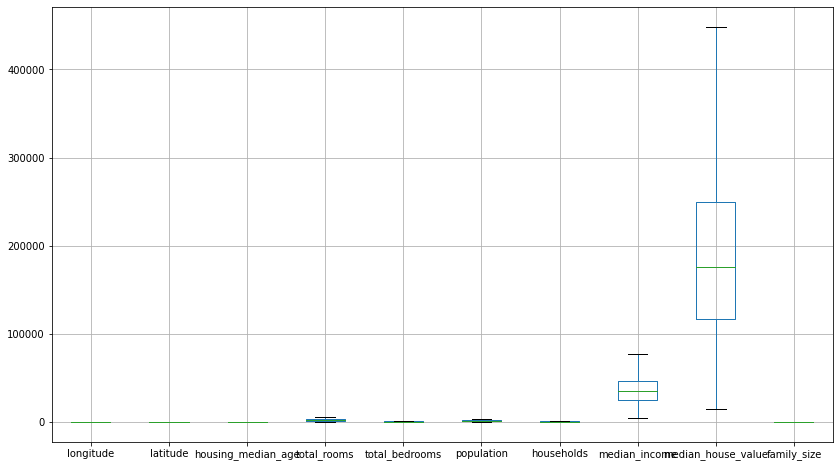

In [21]:
housing_new.boxplot(figsize=(14,8), showfliers=False)

In [22]:
housing_new.housing_median_age.min()
housing_new.housing_median_age.max()
Age_cut = pd.cut(housing_new.housing_median_age, bins=pd.interval_range(start=0, end=55, freq=10))
housing_new['age_cat'] = Age_cut.astype('str')
housing_new.age_cat.value_counts().sort_index()

1.0

52.0

(0, 10]     1487
(10, 20]    4508
(20, 30]    4442
(30, 40]    5044
(40, 50]    2338
Name: age_cat, dtype: int64

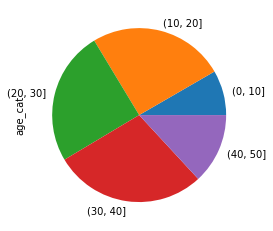

In [23]:
housing_new.age_cat.value_counts().sort_index().plot.pie(figsize=(4,4));

In [24]:
housing_new.median_house_value.min()
housing_new.median_house_value.max()
Value_cut = pd.cut(housing_new.median_house_value, bins=pd.interval_range(start=0, end=500000, freq=100000))
housing_new['value_cat'] = Value_cut.astype('str')
housing_new.value_cat.value_counts().sort_index()

14999.0

482200.0

(0, 100000]         3518
(100000, 200000]    7819
(200000, 300000]    4833
(300000, 400000]    2073
(400000, 500000]     669
Name: value_cat, dtype: int64

In [25]:
housing_new['is_near_ocean'] = ['No']*housing_new.shape[0]
housing_new.is_near_ocean[housing_new.ocean_proximity.isin(['<1H OCEAN','ISLAND','NEAR BAY','NEAR OCEAN'])] = "Yes"

<ipython-input-25-483b2bdebf96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_new.is_near_ocean[housing_new.ocean_proximity.isin(['<1H OCEAN','ISLAND','NEAR BAY','NEAR OCEAN'])] = "Yes"


In [26]:
Value_OceanProximity= pd.crosstab(housing_new.value_cat, housing_new.is_near_ocean)
Value_OceanProximity

is_near_ocean,No,Yes
value_cat,,
"(0, 100000]",2847,671
"(100000, 200000]",2841,4978
"(200000, 300000]",502,4331
"(300000, 400000]",136,1937
"(400000, 500000]",36,633


<AxesSubplot:xlabel='is_near_ocean', ylabel='value_cat'>

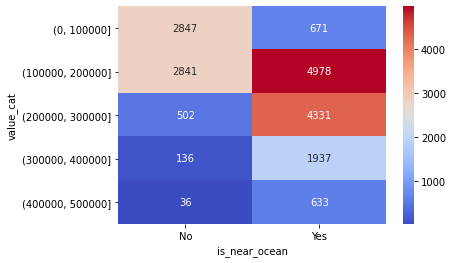

In [27]:
sn.heatmap(Value_OceanProximity, annot=True, fmt="d", cmap='coolwarm')

In [28]:
pd.crosstab(housing_new.value_cat, 
            housing_new.age_cat, 
            normalize=True, 
            margins=True)
pd.crosstab(housing_new.value_cat, 
            housing_new.age_cat, 
            normalize="index")
pd.crosstab(housing_new.value_cat, 
            housing_new.age_cat, 
            normalize="columns")

age_cat,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]",All
value_cat,,,,,,
"(0, 100000]",0.010,0.048,0.051,0.055,0.026,0.190
"(100000, 200000]",0.044,0.113,0.093,0.118,0.054,0.421
"(200000, 300000]",0.019,0.062,0.070,0.071,0.031,0.253
"(300000, 400000]",0.008,0.025,0.027,0.029,0.015,0.103
"(400000, 500000]",0.003,0.006,0.008,0.011,0.005,0.032
All,0.083,0.253,0.249,0.283,0.131,1.000


age_cat,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]"
value_cat,,,,,
"(0, 100000]",0.052,0.252,0.269,0.289,0.138
"(100000, 200000]",0.104,0.267,0.220,0.279,0.129
"(200000, 300000]",0.076,0.246,0.277,0.280,0.121
"(300000, 400000]",0.076,0.238,0.264,0.277,0.145
"(400000, 500000]",0.086,0.173,0.247,0.335,0.159


age_cat,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]"
value_cat,,,,,
"(0, 100000]",0.118,0.189,0.205,0.194,0.199
"(100000, 200000]",0.525,0.445,0.372,0.416,0.415
"(200000, 300000]",0.229,0.247,0.281,0.251,0.233
"(300000, 400000]",0.094,0.097,0.109,0.101,0.114
"(400000, 500000]",0.034,0.022,0.032,0.038,0.039


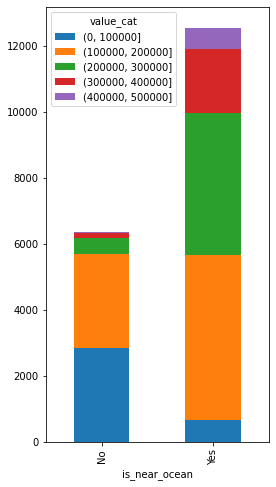

In [29]:
Value_OceanProximity.T.plot.bar(stacked=True, figsize=(4,8));  

<AxesSubplot:xlabel='age_cat'>

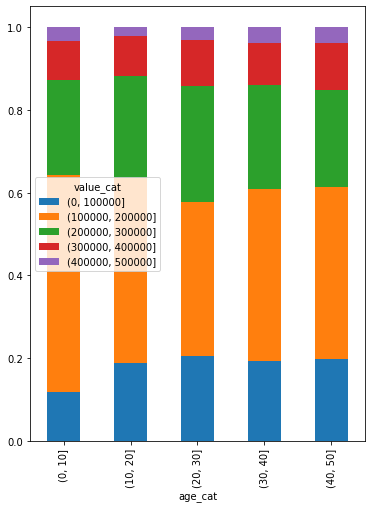

In [30]:
pd.crosstab(housing_new.value_cat, 
            housing_new.age_cat, 
            normalize="columns").T.plot.bar(stacked=True, figsize=(6,8))

### 6.1. One-hot-encoding

There is no variable for one-hot-encoding.

### 6.2. Compare variables

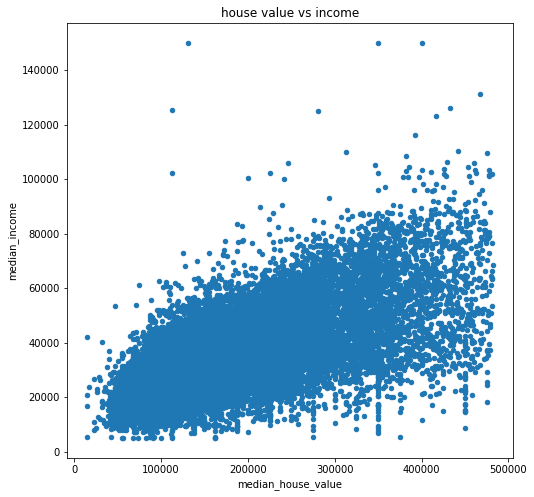

In [31]:
housing_new.plot.scatter(y='median_income',
                        x='median_house_value', 
                        figsize=(8,8),
                        title='house value vs income');

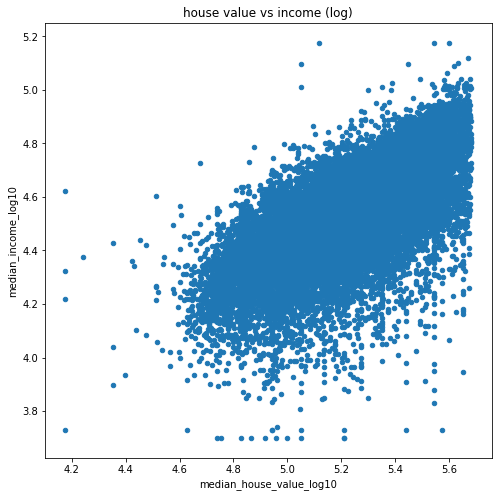

In [32]:
housing_new['median_income_log10'] = (housing_new.median_income+1).apply(np.log10)
housing_new['median_house_value_log10'] = (housing_new.median_house_value+1).apply(np.log10)
housing_new.plot.scatter(y='median_income_log10',
                        x='median_house_value_log10', 
                        figsize=(8,8),
                        title='house value vs income (log)');

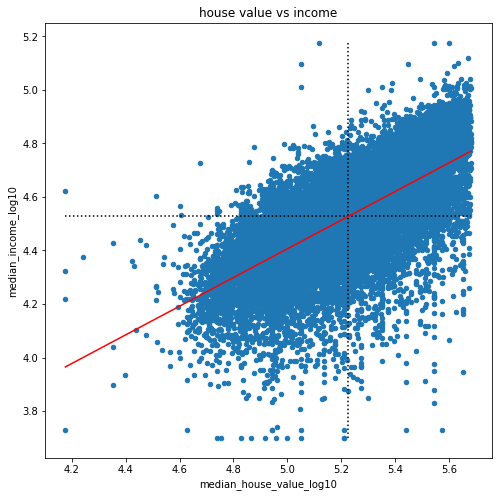

In [33]:

model = GLM.from_formula('median_income_log10 ~ median_house_value_log10', housing_new)
result = model.fit()

housing_new.plot.scatter(y='median_income_log10',
                        x='median_house_value_log10', 
                        figsize=(8,8))
plt.title('house value vs income');
plt.plot([housing_new.median_house_value_log10.mean()]*2,
         [housing_new.median_income_log10.min(),
          housing_new.median_income_log10.max()],
         'k:');
plt.plot([housing_new.median_house_value_log10.min(),
          housing_new.median_house_value_log10.max()],
         [housing_new.median_income_log10.mean()]*2,
         'k:');
plt.plot(np.linspace(housing_new.median_house_value_log10.min(), 
                     housing_new.median_house_value_log10.max(),
                     num=30),
         result.params.Intercept+
         result.params.median_house_value_log10*
         np.linspace(housing_new.median_house_value_log10.min(),                                                             
                     housing_new.median_house_value_log10.max(),num=30),'r');


### 6.3. Gaussianity

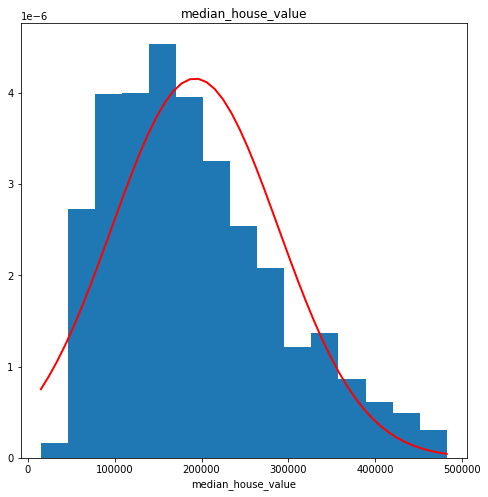

In [34]:
sigma = housing_new.median_house_value.std()
mu = housing_new.median_house_value.mean()
fig, ax = plt.subplots(figsize=(8,8))
count, bins, ignored = plt.hist(housing_new.median_house_value, bins=15, density=True)
dbins = np.linspace(bins[0], bins[-1]) # evenly space numbers over a specified interval
plt.title("median_house_value")
ax.set_xlabel("median_house_value")
# PDF of N(mu, sigma) = 1/(sigma*sqrt(..)) * e(...)^2
plt.plot(dbins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (dbins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r');

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

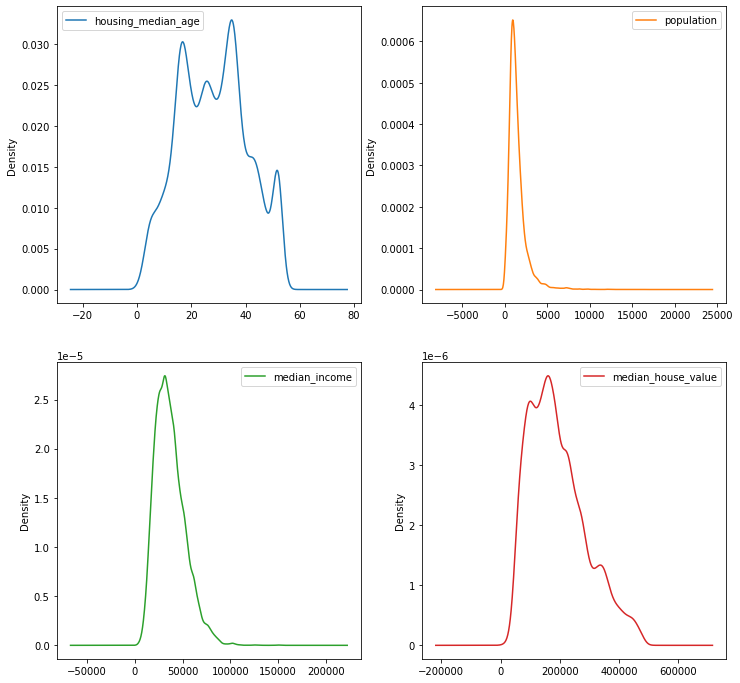

In [35]:
# Kernel Density Estimation (~ histograms)
housing_new.loc[:,['housing_median_age','population','median_income','median_house_value']].plot.kde(subplots=True,
                                                       layout=(2,2),
                                                       sharex=False, 
                                                       figsize=(12,12))
#fig = plt.figure(figsize=(12,12))
#for i,col in enumerate(['housing_median_age','population','median_income','median_house_value']):
#    ax = fig.add_subplot(3, 3, i+1)
#    housing_new[col].plot.kde()
#    plt.title(col)
#fig.tight_layout();

### NORMALIZATION

In [36]:
housing_new[['housing_median_age','total_rooms','total_bedrooms', 'population','median_income','median_house_value']].describe()

,housing_median_age,total_rooms,total_bedrooms,population,median_income,median_house_value
count,18912.000,18912.000,18912.000,18912.000,18912.000,18912.000
mean,28.281,2657.478,545.510,1426.346,36923.923,192482.101
std,12.547,2182.547,421.388,1088.805,15623.933,95983.112
min,1.000,2.000,2.000,5.000,4999.000,14999.000
25%,18.000,1469.000,301.000,794.750,25417.000,116700.000
50%,28.000,2144.000,442.000,1171.000,34784.000,175300.000
75%,37.000,3165.000,654.000,1727.000,46111.000,249500.000
max,52.000,39320.000,6210.000,16305.000,150001.000,482200.000


In [37]:
min_max_scaler = preprocessing.MinMaxScaler()
housing_new[['housing_median_age_min_max', 'total_rooms_min_max','total_bedrooms_min_max','population_min_max', 'median_income_min_max', 'median_house_value_min_max']] = min_max_scaler.fit_transform(housing_new[['housing_median_age', 'total_rooms','total_bedrooms','population', 'median_income', 'median_house_value']])

std_scaler = preprocessing.StandardScaler()
housing_new[['housing_median_age_std', 'total_rooms_std','total_bedrooms_std','population_std', 'median_income_std', 'median_house_value_std']]= preprocessing.scale(housing_new[['housing_median_age', 'total_rooms','total_bedrooms','population', 'median_income', 'median_house_value']])

def add_boxcox_field(col):
    x, _= boxcox(housing_new[col])
    housing_new[col+'_bx'] = x

for col in ['housing_median_age', 'total_rooms','total_bedrooms','population', 'median_income', 'median_house_value']:
    add_boxcox_field(col)

In [38]:
housing_new.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'family_size', 'age_cat',
       'value_cat', 'is_near_ocean', 'median_income_log10',
       'median_house_value_log10', 'housing_median_age_min_max',
       'total_rooms_min_max', 'total_bedrooms_min_max', 'population_min_max',
       'median_income_min_max', 'median_house_value_min_max',
       'housing_median_age_std', 'total_rooms_std', 'total_bedrooms_std',
       'population_std', 'median_income_std', 'median_house_value_std',
       'housing_median_age_bx', 'total_rooms_bx', 'total_bedrooms_bx',
       'population_bx', 'median_income_bx', 'median_house_value_bx'],
      dtype='object')

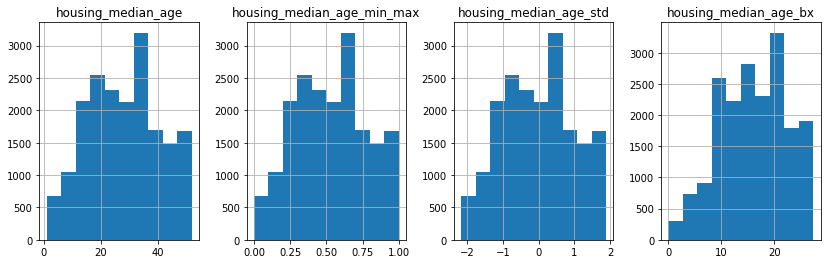

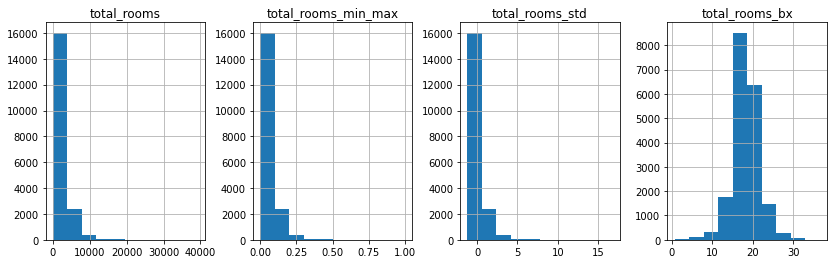

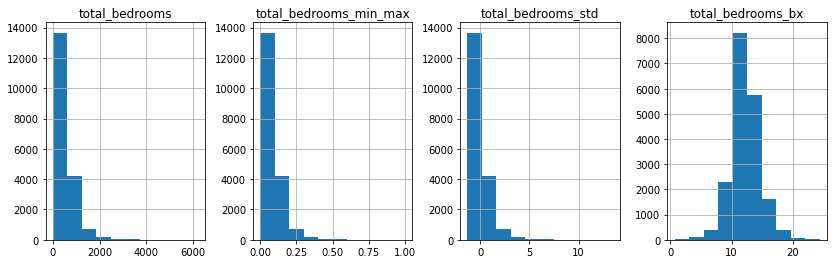

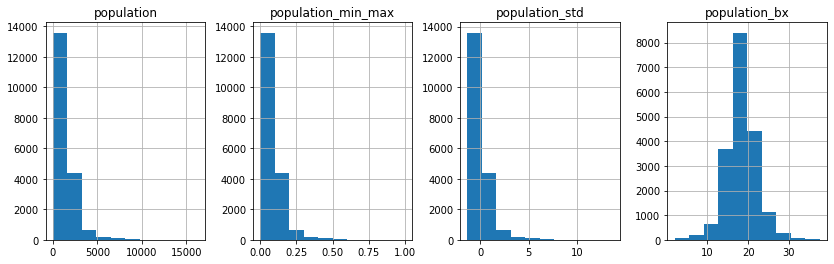

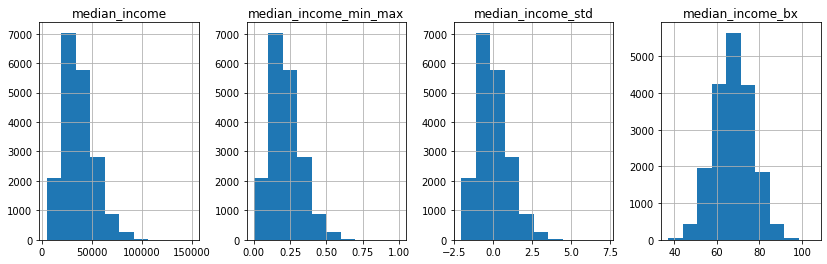

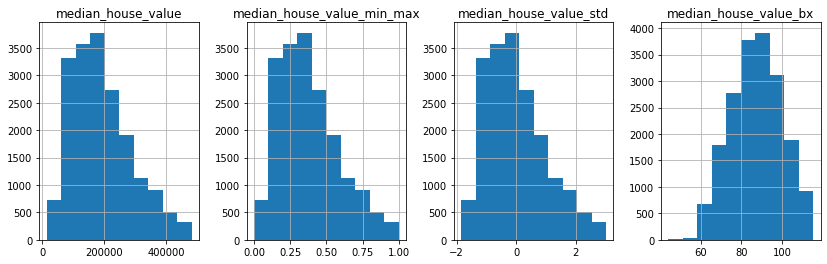

In [39]:
def print_norm_hist(col):
    housing_new[[col, col+'_min_max', col+'_std', col+'_bx']].hist(figsize=(14,4), layout=(1,4))
    
for col in ['housing_median_age','total_rooms','total_bedrooms', 'population','median_income','median_house_value']:
    print_norm_hist(col)

### STORE RESULTS

Shuffle data to avoid ordering biases

In [40]:
np.random.seed(167)
housing_new = housing_new.sample(frac=1).reset_index(drop=True)

In [41]:
housing_new.to_csv('housing_post.csv', header=True, index=False)

In [42]:
pd.read_csv('housing_post.csv', header=0, delimiter=',').head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,total_bedrooms_std,population_std,median_income_std,median_house_value_std,housing_median_age_bx,total_rooms_bx,total_bedrooms_bx,population_bx,median_income_bx,median_house_value_bx
0,-117.07,33.15,17.0,1893.0,297.0,936.0,287.0,51842.0,157700.0,<1H OCEAN,...,-0.590,-0.450,0.955,-0.362,10.605,17.625,10.797,17.046,76.508,85.044
1,-118.23,34.07,40.0,506.0,119.0,397.0,114.0,31944.0,143800.0,<1H OCEAN,...,-1.012,-0.945,-0.319,-0.507,22.074,12.375,8.117,13.148,66.053,82.911
2,-118.92,35.13,29.0,1297.0,262.0,909.0,253.0,19236.0,106300.0,INLAND,...,-0.673,-0.475,-1.132,-0.898,16.837,15.976,10.399,16.899,56.564,76.277
3,-121.24,38.75,5.0,9137.0,1368.0,3667.0,1294.0,54896.0,229600.0,INLAND,...,1.952,2.058,1.150,0.387,3.248,26.001,16.561,25.132,77.844,94.285
4,-118.35,33.97,26.0,1725.0,431.0,1130.0,404.0,32708.0,128100.0,<1H OCEAN,...,-0.272,-0.272,-0.270,-0.671,15.341,17.208,12.041,18.012,66.530,80.310
